In [1]:
import os
import time
from io import StringIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

#preprocessing
from sklearn.model_selection import TimeSeriesSplit

from sklearn.impute import SimpleImputer
#model
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from prophet import Prophet

#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from google.cloud import storage

In [2]:
def read_data_from_gcs(bucket_name, folder, filename, delimiter=','):
    start_time = time.time()  # Start measuring time
    blob = storage_client.get_bucket(bucket_name).blob(f'{folder}/{filename}')
    csv_data = blob.download_as_text()
    df = pd.read_csv(StringIO(csv_data), delimiter=delimiter)
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f"Read {filename} complete. Elapsed time: {elapsed_time:.2f} seconds")
    return df

def remove_lawyers(df, lawyer_ids):
    filtered_df = df[~df['lawyer_id'].isin(lawyer_ids)]
    return filtered_df

# Function to create lagged features for time series data
def create_lagged_features(data, lag):
    lagged_data = data.copy()
    for i in range(1, lag + 1):
        lagged_data[f'Lag_{i}'] = data['count'].shift(i)
    return lagged_data

def data_process_ml(df, train_index, test_index):
    
    df = df.set_index('date', inplace=False)

    lag = 7  # Number of lagged values, adjust as needed
    # Apply the function to create lagged features
    lagged_df = create_lagged_features(df, lag)
    
    X = lagged_df.drop(['count'], axis=1)
    y = lagged_df['count']
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    return X_train, y_train, X_test, y_test

def model_linear_regression(X_train, y_train, X_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred
    
def model_lgb(X_train, y_train, X_test):
    model = lgb.LGBMRegressor(verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred
    
def model_xgboost(X_train, y_train, X_test):
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def produce_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return [mae, rmse, mape]

def visualize(df, x, y):
    # Set a Seaborn style and color palette
    sns.set_style("whitegrid")
    sns.set_palette("tab10")

    # Create a line plot
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    sns.lineplot(data=df, x=x, y=y)

    # Customize the plot
    plt.title('Daily Chat Consultations', fontsize=16)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    # Add grid lines
    plt.grid(True, alpha=0.5)

    # Show the plot
    plt.tight_layout()  # Ensure all elements fit nicely
    plt.show()
    
    
def metrics_results(model_score):
    num_rows = len(model_score)
    # Initialize a list to store the column sums
    column_sums = []

    # Calculate the sum of each column
    for col in range(len(model_score[0])):
        col_sum = sum(row[col] for row in model_score)
        column_sums.append(col_sum / num_rows)

    return column_sums

def data_process_stats(df, train_index, test_index):
    time_series = df['count']
    train_data, test_data = time_series[train_index], time_series[test_index]
    return train_data, test_data

def model_auto_arima(train_data, test_data):
    auto_model = auto_arima(train_data, seasonal=True, m=7, trace=True)
    n_forecast = len(test_data)
    y_pred, conf_int = auto_model.predict(n_forecast, return_conf_int=True)
    return y_pred

def data_process_prophet(df, train_index, test_index):
    df = df.rename(columns={'date': 'ds', 'count': 'y'}, inplace=False)
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]
    return train_data, test_data

def model_prophet(train_data_pr, test_data_pr):
    model = Prophet()
    model.fit(train_data_pr)
    y_pred = model.predict(test_data_pr)
    return y_pred['yhat']

In [3]:
# Set path
relative_path = '../../deep-flash-sa.json'
file_path = os.path.abspath(relative_path)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = file_path
storage_client = storage.Client()

In [4]:
df_consultations = read_data_from_gcs('perqara-dendrobium', 'raw/postgres/csv/consultations', 'consultations.csv', delimiter='|')

Read consultations.csv complete. Elapsed time: 7.03 seconds


In [ ]:
def run():
    
    #get data consultation
    data_consultation = get_data_consultation()
    #get data availibity
    data_availability = get_data_availability()
    #get data web_visitor
    data_web = get_data_web_visitor()
    #transform consultation
    
    #transform availability
    
    #transform web visitor
        
    #merge
    
    #load

In [7]:
def get_data_consultation():
    data = read_data_from_gcs('perqara-dendrobium', 'raw/postgres/csv/consultations', 'consultations.csv', delimiter='|')
    return data

def get_data_availability():
    data = df_availability_instants = read_data_from_gcs('perqara-dendrobium', 'raw/postgres/csv/availability_instants', 'availability_instants.csv', delimiter=',')
    return data
    
def get_data_web_visitor():
    data = pd.read_csv('website-visitor_20231114.csv')
    return data

In [156]:
def remove_lawyer(df, lawyer_ids):
    filtered_df = df[~df['lawyer_id'].isin(lawyer_ids)]
    return filtered_df

def filter_status(df):
    filtered_df = df[df['status'] == 600]
    return filtered_df

def cast_column(df, columns):
    data = df.copy()
    for column in columns:
        data[column] = pd.to_datetime(data[column])
    return data

def count_daily_consultations(df):
    count = df['created_at'].to_frame().reset_index(drop=True)
    count.set_index('created_at', inplace=True)
    df_daily_count = count.resample('D').size().reset_index()
    return df_daily_count

def rename_columns_consultation(df):
    df.rename(columns={'created_at': 'date', 0: 'count'}, inplace=True)
    return df

# Function to create lagged features for time series data
def create_lagged_features(data, lag):
    lagged_data = data.copy()
    for i in range(1, lag + 1):
        lagged_data[f'Lag_{i}'] = data['count'].shift(i)
    data = lagged_data.fillna(lagged_data.mean(numeric_only=True))
    return data

def filter_columns(df, column):
    data = df[column]
    return data

def calculate_duration(df):
    df['duration'] = (df['end_datetime'] - df['start_datetime']).astype('timedelta64[m]') / 60
    return df

def extract_date(df, column):
    df['date'] = df[column].dt.date
    df['date'] = pd.to_datetime(df['date'])
    return df

def filter_working_hours(df):
    working_hours_mask = (df['start_datetime'].dt.hour >= 10) & (df['end_datetime'].dt.hour <= 18)
    return df[working_hours_mask]

def filter_late_hours(df):
    late_hours_mask = (df['end_datetime'].dt.hour > 18) & (df['end_datetime'].dt.hour <= 24)
    return df[late_hours_mask]

def get_daily_lawyer_count(df, time_column, count_column):
    return df.groupby(df[time_column].dt.date)[count_column].nunique()

def fill_date_range(daily_count):
    date_range = pd.date_range(start=daily_count.index.min(), end=daily_count.index.max(), freq='D')
    data = daily_count.reindex(date_range, fill_value=0).fillna(0)
    data = data.reset_index()
    return data

def rename_index(df):
    df = df.rename(columns={'index': 'date'})
    return df

def create_df_lawyer_count(working_hours_lawyers, late_hours_lawyers):
    new_data = {'working_hours_lawyers': working_hours_lawyers, 'late_hours_lawyers': late_hours_lawyers}
    return pd.DataFrame(new_data)

def rename_columns_website(df):
    column_mapping = {'event_date': 'date', 'f0_': 'web_visitor'}
    return df.rename(columns=column_mapping)

def convert_date_to_datetime(df):
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    return df

def generate_date_range(start_date, end_date):
    return pd.date_range(start=start_date, end=end_date)

def calculate_mean_count(df, count_column):
    return df[count_column].mean()

def create_new_data(date_range, mean_count):
    new_data = {'date': date_range, 'web_visitor': mean_count}
    return pd.DataFrame(new_data)

def concatenate_dataframes(df1, df2):
    return pd.concat([df1, df2]).sort_values('date')


In [157]:
def transform_consultation(df):
    # cleaning
    df = remove_lawyers(df, [36, 38, 48, 120, 192, 195])
    # filter status 6000
    df = filter_status(df)
    # cast columns
    df = cast_column(df, ['created_at'])
    # count consultations
    df = count_daily_consultations(df)
    # rename column
    df = rename_columns_consultation(df)
    # create lagged feature
    df = create_lagged_features(df, 7)
    return df
    
def transform_availability(df):
    # cleaning
    df = remove_lawyers(df, [36, 38, 48, 120, 192, 195])
    # filter column
    df = filter_columns(df, ['lawyer_id', 'start_datetime', 'end_datetime', 'created_at'])
    # cast columns
    df = cast_column(df, ['start_datetime', 'end_datetime', 'created_at'])
    # calculate duration
    df = calculate_duration(df)
    # extract date
    df = extract_date(df, 'created_at')
    # filter working hours
    df_working_hours = filter_working_hours(df)
    # filter late hours
    df_late_hours = filter_late_hours(df)
    # get daily lawyer count for working hours
    working_hours_lawyers = get_daily_lawyer_count(df_working_hours, 'start_datetime', 'lawyer_id')
    # get daily lawyer count for late hours
    late_hours_lawyers = get_daily_lawyer_count(df_late_hours, 'start_datetime', 'lawyer_id')
    # create daily count DataFrame
    df_new = create_df_lawyer_count(working_hours_lawyers, late_hours_lawyers)
    # fill date range
    df_new = fill_date_range(df_new)
    # rename
    df_new = rename_index(df_new)
    return df_new
    
def transform_web_visitor(df):
    
    df = rename_columns_website(df)
    
    df = convert_date_to_datetime(df)
    
    # Generate date range
    date_range = generate_date_range('2023-05-06', '2023-06-25')

    # Calculate mean count
    mean_count = calculate_mean_count(df, 'web_visitor')

    # Create new data
    new_rows = create_new_data(date_range, mean_count)

    # Concatenate DataFrames
    df = concatenate_dataframes(df, new_rows)
    
    return df

In [179]:
def filter_date_range(df, start_date, end_date):
    mask = (df['date'] >= start_date) & (df['date'] <= end_date)
    return df[mask]

def merge_dataframes(df1, df2, df3):
    # Merge the DataFrames on the 'date' column
    merged_df = pd.merge(df1, df2, on='date', how='outer')
    merged_df = pd.merge(merged_df, df3, on='date', how='outer')
    
    # Sort the DataFrame by 'date'
    merged_df = merged_df.sort_values('date')
    
    return merged_df

In [60]:
data_consultation = get_data_consultation()
data_availability = get_data_availability()
data_web = get_data_web_visitor()

Read consultations.csv complete. Elapsed time: 38.54 seconds
Read availability_instants.csv complete. Elapsed time: 1.05 seconds


In [158]:
data_consultation_tr = transform_consultation(data_consultation)
data_availability_tr = transform_availability(data_availability)
data_web_tr = transform_web_visitor(data_web)

In [171]:
data_consultation_tr = filter_date_range(data_consultation_tr, '2023-05-06', '2023-11-13')
data_availability_tr = filter_date_range(data_availability_tr, '2023-05-06', '2023-11-13')
data_web_tr = filter_date_range(data_web_tr, '2023-05-06', '2023-11-13')

In [180]:
df_merged = merge_dataframes(data_consultation_tr, data_availability_tr, data_web_tr)

In [181]:
df_merged

,date,count,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,working_hours_lawyers,late_hours_lawyers,web_visitor
0,2023-05-06,1,15.432836,15.3,15.175879,15.020202,15.020305,14.892857,14.789744,0.0,1.0,533.652482
1,2023-05-07,0,1.000000,15.3,15.175879,15.020202,15.020305,14.892857,14.789744,0.0,0.0,533.652482
2,2023-05-08,0,0.000000,1.0,15.175879,15.020202,15.020305,14.892857,14.789744,1.0,1.0,533.652482
3,2023-05-09,3,0.000000,0.0,1.000000,15.020202,15.020305,14.892857,14.789744,2.0,0.0,533.652482
4,2023-05-10,0,3.000000,0.0,0.000000,1.000000,15.020305,14.892857,14.789744,0.0,0.0,533.652482
...,...,...,...,...,...,...,...,...,...,...,...,...
187,2023-11-09,30,39.000000,43.0,48.000000,27.000000,23.000000,29.000000,27.000000,21.0,6.0,519.000000
188,2023-11-10,27,30.000000,39.0,43.000000,48.000000,27.000000,23.000000,29.000000,22.0,7.0,505.000000
189,2023-11-11,11,27.000000,30.0,39.000000,43.000000,48.000000,27.000000,23.000000,3.0,0.0,255.000000
190,2023-11-12,0,11.000000,27.0,30.000000,39.000000,43.000000,48.000000,27.000000,0.0,0.0,217.000000


In [ ]:
def load():
    

In [ ]:
# Feature Engineering Pipeline
def get_data():
    

def validation():
    
    
def load():
    

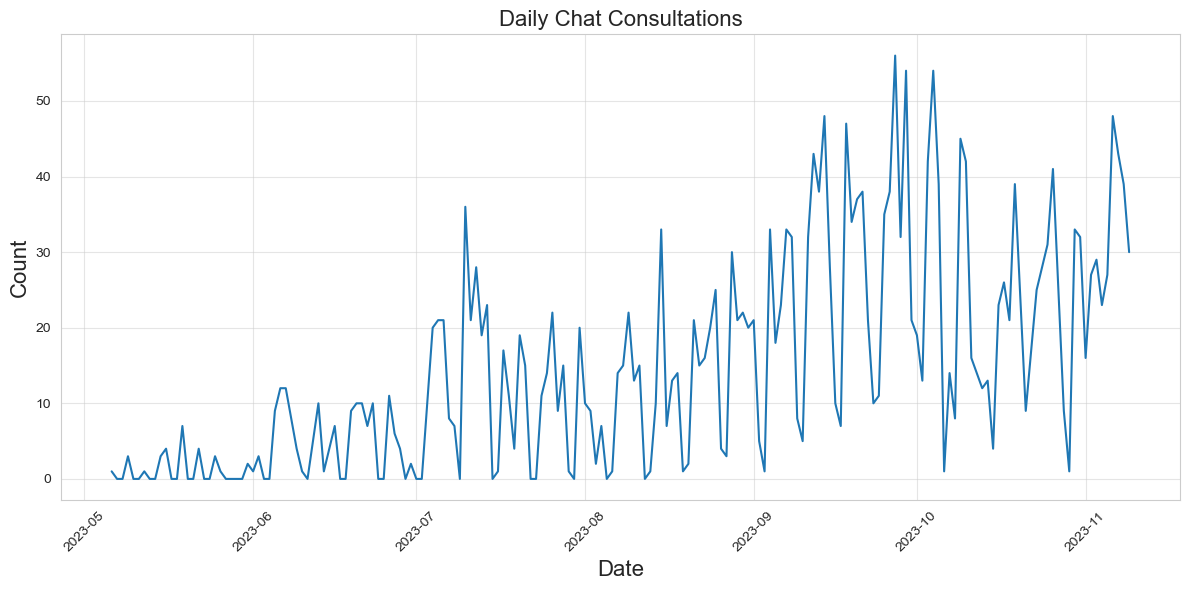

In [159]:
visualize(df_daily_count, 'date', 'count')

In [171]:
exogenous_features = list(df.iloc[:, 1:].columns)

n_splits = 5  # You can adjust the number of splits as needed
tscv = TimeSeriesSplit(n_splits=n_splits)

scores_prophet = []

df.reset_index(inplace=True)

for i, (train_index, test_index) in enumerate(tscv.split(df)):
    print(f"Fold {i}:")
    print(train_index)
    print(test_index)
    
    train_data_pr, test_data_pr = df.iloc[train_index], df.iloc[test_index]
    model = Prophet()
    for feature in exogenous_features:
        model.add_regressor(feature)
    
    model.fit(train_data_pr[["date", "count"] + exogenous_features].rename(columns={"date": "ds", "count": "y"}))
    y_pred = model.predict(test_data_pr[["date", "count"] + exogenous_features].rename(columns={"date": "ds", "count": "y"}))
    y_pred_new = y_pred['yhat']
        
    metrics_prophet = produce_metrics(test_data_pr['count'], y_pred_new)
    
    scores_prophet.append(metrics_prophet)
    
    print(f"Fold metrics prophet: {scores_prophet}")
    
print("Metrics prophet:", scores_prophet)

14:11:13 - cmdstanpy - INFO - Chain [1] start processing


Fold 0:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
[33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56
 57 58 59 60 61 62 63]


14:11:13 - cmdstanpy - INFO - Chain [1] done processing
14:11:14 - cmdstanpy - INFO - Chain [1] start processing
14:11:14 - cmdstanpy - INFO - Chain [1] done processing
14:11:14 - cmdstanpy - INFO - Chain [1] start processing


Fold metrics prophet: [[3.9898672961536885, 5.2932459342556655, 2175857771036246.2]]
Fold 1:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
[64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87
 88 89 90 91 92 93 94]
Fold metrics prophet: [[3.9898672961536885, 5.2932459342556655, 2175857771036246.2], [4.889642904833042, 7.1894003267088396, 1930561147833565.8]]
Fold 2:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94]
[ 95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125]


14:11:14 - cmdstanpy - INFO - Chain [1] done processing
14:11:14 - cmdstanpy - INFO - Chain [1] start processing
14:11:14 - cmdstanpy - INFO - Chain [1] done processing
14:11:14 - cmdstanpy - INFO - Chain [1] start processing
14:11:14 - cmdstanpy - INFO - Chain [1] done processing


Fold metrics prophet: [[3.9898672961536885, 5.2932459342556655, 2175857771036246.2], [4.889642904833042, 7.1894003267088396, 1930561147833565.8], [5.581960427316469, 6.5740787485787555, 589681573259074.4]]
Fold 3:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125]
[126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156]
Fold metrics prophet: [[3.9898672961536885, 5.2932459342556655, 2175857771036246.2], [4.889642904833042, 7.1894003267088396, 1930561147833565.8], [

In [172]:
time_series = df['count']

scores_arimax = []

n_splits = 5  # You can adjust the number of splits as needed
tscv = TimeSeriesSplit(n_splits=n_splits)

for i, (train_index, test_index) in enumerate(tscv.split(df)):
    print(f"Fold {i}:")
    print(train_index)
    print(test_index)
    
    time_series = df['count']
    train_data, test_data = time_series[train_index], time_series[test_index]
    
#     model = auto_arima(train_data, exogenous=df_ml_vis.iloc[:, 1:].iloc[train_index], seasonal=True, m=7, trace=True)
    model = auto_arima(train_data, seasonal=True, m=7, trace=True)
    n_forecast = len(test_data)
    y_pred, conf_int = model.predict(n_forecast, return_conf_int=True)
    
    metrics_arimax = produce_metrics(test_data, y_pred)
    
    scores_arimax.append(metrics_arimax)
    
    print(f"Fold metrics arimax: {metrics_arimax}")
    
print("Metrics arimax:", scores_arimax)

Fold 0:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
[33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56
 57 58 59 60 61 62 63]
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=176.689, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=170.134, Time=0.02 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=168.057, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=184.949, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=166.130, Time=0.02 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=168.041, Time=0.04 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=168.056, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[7] intercept   : AIC=168.077, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=168.309, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=16

 ARIMA(2,1,1)(0,0,2)[7]             : AIC=616.152, Time=0.16 sec
 ARIMA(2,1,1)(2,0,0)[7]             : AIC=604.061, Time=0.17 sec
 ARIMA(2,1,1)(2,0,2)[7]             : AIC=inf, Time=0.34 sec
 ARIMA(2,1,0)(1,0,1)[7]             : AIC=609.166, Time=0.08 sec
 ARIMA(3,1,1)(1,0,1)[7]             : AIC=600.457, Time=0.22 sec
 ARIMA(2,1,2)(1,0,1)[7]             : AIC=597.989, Time=0.11 sec
 ARIMA(2,1,2)(0,0,1)[7]             : AIC=618.725, Time=0.07 sec
 ARIMA(2,1,2)(1,0,0)[7]             : AIC=609.320, Time=0.09 sec
 ARIMA(2,1,2)(2,0,1)[7]             : AIC=599.750, Time=0.26 sec
 ARIMA(2,1,2)(1,0,2)[7]             : AIC=599.653, Time=0.21 sec
 ARIMA(2,1,2)(0,0,0)[7]             : AIC=632.224, Time=0.07 sec
 ARIMA(2,1,2)(0,0,2)[7]             : AIC=614.906, Time=0.14 sec
 ARIMA(2,1,2)(2,0,0)[7]             : AIC=603.553, Time=0.16 sec
 ARIMA(2,1,2)(2,0,2)[7]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,2)(1,0,1)[7]             : AIC=600.426, Time=0.13 sec
 ARIMA(3,1,2)(1,0,1)[7]          

 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=1109.114, Time=0.41 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=1107.288, Time=0.35 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=1175.204, Time=0.10 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=1107.851, Time=0.39 sec
 ARIMA(0,1,2)(2,0,1)[7] intercept   : AIC=1108.097, Time=0.27 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=1140.845, Time=0.21 sec
 ARIMA(1,1,2)(2,0,1)[7] intercept   : AIC=1108.223, Time=0.33 sec
 ARIMA(0,1,1)(2,0,1)[7]             : AIC=1105.242, Time=0.14 sec
 ARIMA(0,1,1)(1,0,1)[7]             : AIC=1106.522, Time=0.06 sec
 ARIMA(0,1,1)(2,0,0)[7]             : AIC=1114.657, Time=0.09 sec
 ARIMA(0,1,1)(2,0,2)[7]             : AIC=1107.232, Time=0.19 sec
 ARIMA(0,1,1)(1,0,0)[7]             : AIC=1139.525, Time=0.03 sec
 ARIMA(0,1,1)(1,0,2)[7]             : AIC=1105.400, Time=0.17 sec
 ARIMA(0,1,0)(2,0,1)[7]             : AIC=1173.212, Time=0.10 sec
 ARIMA(1,1,1)(2,0,1)[7]             : AIC=1106.148, Time=0.20 sec
 ARIMA(0,1

In [173]:
df.set_index('date', inplace=True)

In [174]:
scores_lr = []
scores_lgb = []
scores_xgb = []

n_splits = 5  # You can adjust the number of splits as needed
tscv = TimeSeriesSplit(n_splits=n_splits)
for i, (train_index, test_index) in enumerate(tscv.split(df)):

    X = df.drop(['count'], axis=1)
    y = df['count']

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    y_pred_lr = model_linear_regression(X_train, y_train, X_test)
    y_pred_lgb = model_lgb(X_train, y_train, X_test)
    y_pred_xgb = model_xgboost(X_train, y_train, X_test)
    
    metrics_lr = produce_metrics(y_test, y_pred_lr)
    metrics_lgb = produce_metrics(y_test, y_pred_lgb)
    metrics_xgb = produce_metrics(y_test, y_pred_xgb)
    
    scores_lr.append(metrics_lr)
    scores_lgb.append(metrics_lgb)
    scores_xgb.append(metrics_xgb)
    
    print(f"Fold RMSE lr: {metrics_lr}")
    print(f"Fold RMSE lgb: {metrics_lgb}")
    print(f"Fold RMSE xgb: {metrics_xgb}")
    
print("Metrics lr:", scores_lr)
print("Metrics lgb:", scores_lgb)
print("Metrics xgb:", scores_xgb)

Fold RMSE lr: [2.912340913369324, 3.815512185999089, 1770840022326009.5]
Fold RMSE lgb: [5.483870967741935, 7.4357462692486465, 2324438517352514.0]
Fold RMSE xgb: [4.38008353090094, 5.5894941095803174, 1534484236104605.5]
Fold RMSE lr: [5.790720197927094, 7.979462819132653, 1716080264809791.2]
Fold RMSE lgb: [6.311945938290115, 9.022423360949103, 1460800554577112.8]
Fold RMSE xgb: [7.343339558540573, 10.151261025061412, 741039378082122.9]
Fold RMSE lr: [4.448942658017438, 5.604011985025349, 469703132072527.2]
Fold RMSE lgb: [4.6603017626072845, 6.392057430591235, 205423690154862.72]
Fold RMSE xgb: [3.934983306354092, 5.392809177671181, 355202038945462.1]
Fold RMSE lr: [9.46024827150132, 11.104641044707991, 1.0640202314795661]
Fold RMSE lgb: [10.007230255622597, 12.681662371567997, 0.8037078147349088]
Fold RMSE xgb: [12.400182177943568, 14.889908392586417, 0.8316100501553639]
Fold RMSE lr: [6.069648111680109, 8.080777132915406, 0.5154495832395026]
Fold RMSE lgb: [6.1038899499864225, 7.4

In [175]:
avg_lr = metrics_results(scores_lr)
avg_lgb = metrics_results(scores_lgb)
avg_xgb = metrics_results(scores_xgb)
avg_arimax = metrics_results(scores_arimax)
avg_prophet = metrics_results(scores_prophet)

# Create a Pandas DataFrame
df_model = pd.DataFrame({'Model': ['Linear Regression', 'LightGBM', 'XGBoost', 'Arimax', 'Prophet']})
df_res = pd.DataFrame([avg_lr, avg_lgb, avg_xgb, avg_arimax, avg_prophet])
df_res.columns = ['MAE', 'RMSE', 'MAPE']
df_final_scores = pd.concat([df_model, df_res], axis=1)
df_final_scores

,Model,MAE,RMSE,MAPE
0,Linear Regression,5.736380,7.316881,7.913247e+14
1,LightGBM,6.513448,8.599496,7.981326e+14
2,XGBoost,6.776377,8.687010,5.261451e+14
3,Arimax,8.433029,10.734031,2.069703e+15
4,Prophet,5.904383,7.622508,9.392201e+14
